# thumb

> Fill in a module description here

In [ ]:
#| default_exp thumb

In [ ]:
#|export
import io, base64, re
import nbformat
from PIL import Image
from fastcore.foundation import L
from fastcore.test import test_fail
from io import BytesIO

## Get an image from a notebook

Note: this only works for `png` images.  Other file types will not work at the moment.

In [ ]:
#|export
def _decode_img(base64_str):
    img = Image.open(BytesIO(base64.b64decode(base64_str)))
    if img.mode == "RGBA":
        img = img.convert("RGB")
    return img

def get_img(nb_path, label='thumbnail'):
    "Get image from notebook with a cell comment #|label: {label}"
    out_plots = None
    lbl = re.compile(f'#\|(\s*)label:(\s*){label}')
    nb = nbformat.read(open(nb_path), as_version=4)
    for cell in nb.cells:
        if lbl.search(cell.source):
            out_plots = [x for x in cell.outputs if x.output_type == "display_data" and 'data' in x]
            if out_plots:
                data = out_plots[0]['data']
                if 'image/png' not in data: 
                    raise Exception(f'{nb_path}: thumbnails are only supported for `image/png`, found {data.keys()}')
                return _decode_img(data['image/png'])
            else:
                raise Exception(f'{nb_path}: cell with `#|label: {label}` does not have an output type of `display_data`')
    if out_plots is None:
        raise Exception(f'{nb_path} does not contain a cell with `#|label: {label}`')

`get_img` allows you to get images from cells that contain a certain label. For example, consider the following cell in `test_nbs/geom_col.ipynb`:

```python
#|label: two_variable_bar_plot
#|fig-cap: Two variable bar plot

(ggplot(df, aes(x='variable', y='value', fill='category'))
 + geom_col(stat='identity', position='dodge'))
```

You can extract the plot from that notebook like this:

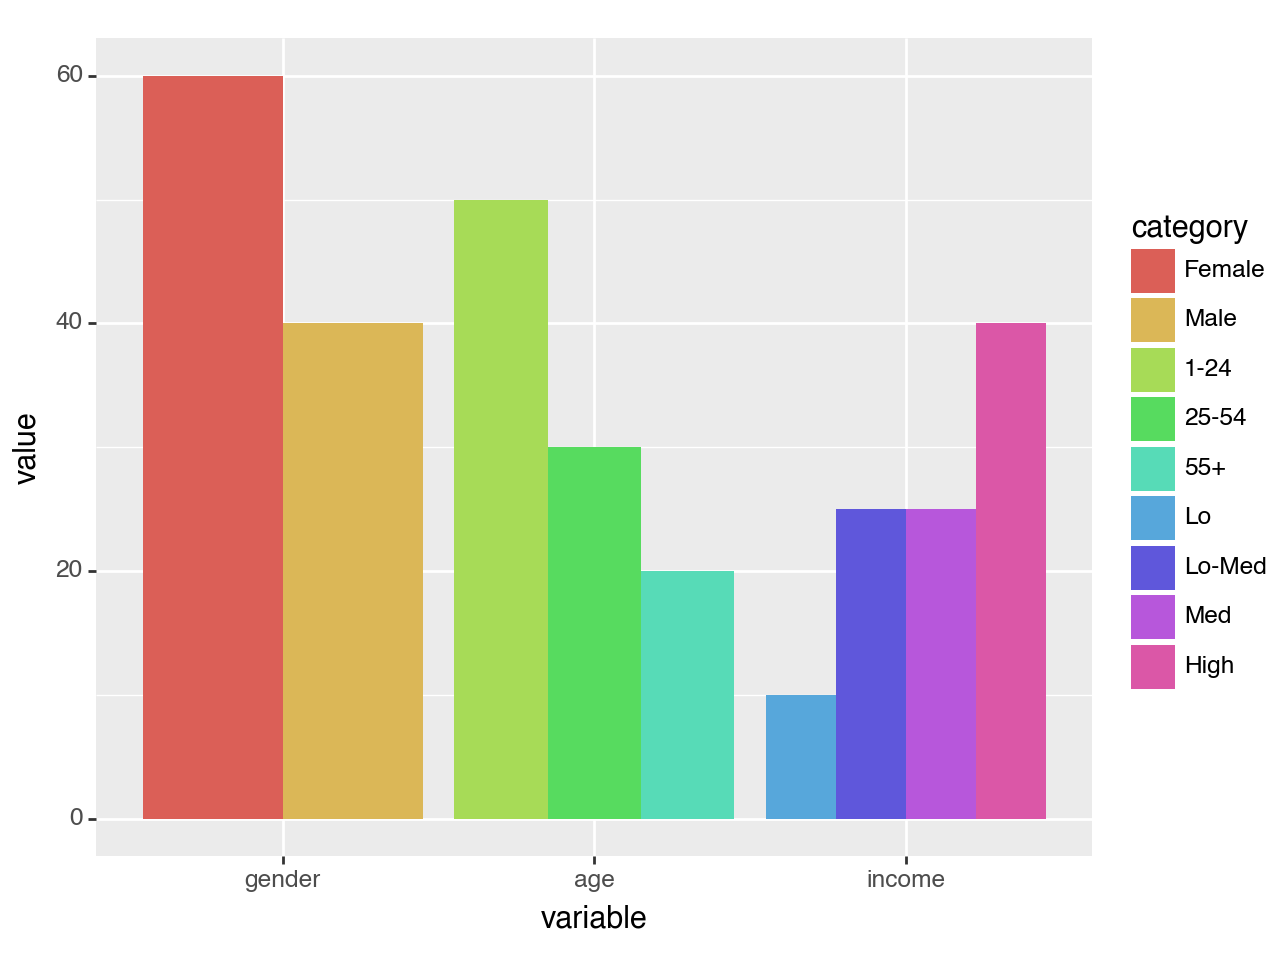

In [ ]:
img = get_img('_test_nbs/geom_col.ipynb', 'two_variable_bar_plot')
img

In [ ]:
# test if you provide a label that doesn't exist
test_fail(get_img, contains='test_nbs/geom_col.ipynb does not contain a cell with `#|label: does_not_exist`', 
          args=('_test_nbs/geom_col.ipynb', 'does_not_exist'))

# test if you label a cell that doesn't have a plot like a dataframe
test_fail(get_img, contains='test_nbs/geom_col.ipynb: cell with `#|label: no_plot` does not have an output type of `display_data`',
          args=('_test_nbs/geom_col.ipynb', 'no_plot'))

# make sure image is a PngImageFile
assert isinstance(img, Image.Image)

## Turn image into thumbnail

The image above is too big!  We can turn it into a thumbnail like so:

In [ ]:
#|export
def img2thumb(img:Image.Image, size=(260,260)):
    "Convert image to thumbnail."
    thumb_size = size[0] * 2, size[1] * 2
    img.thumbnail(thumb_size)
    return img

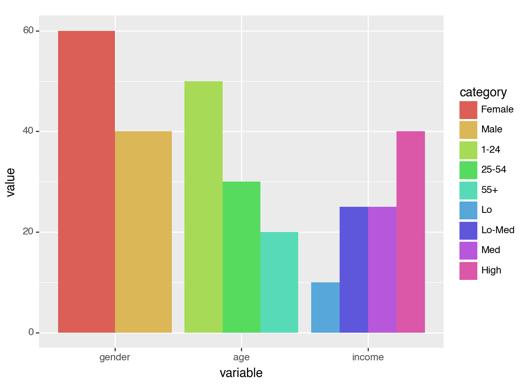

In [ ]:
img2thumb(img)

## Get a thumbnail directly from a notebook

In [ ]:
#|export
def nb2thumb(nb_path, label='thumbnail', size=(260,260)) -> Image.Image:
    "Extract thumbnail corresponding to the cell with the comment `#|label: {label}` from a notebook."
    img = get_img(nb_path=nb_path, label=label)
    return img2thumb(img, size=size)

`nb2thumb` allows us to get a thumbnail directly from a notebook:

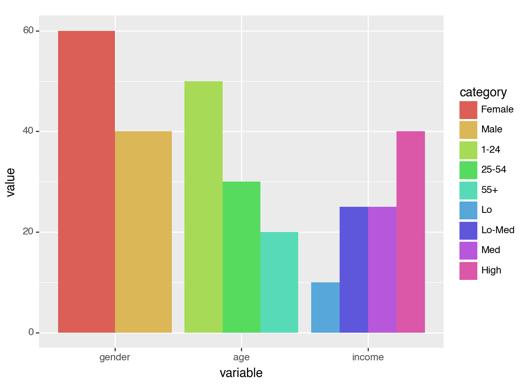

In [ ]:
thumb = nb2thumb('_test_nbs/geom_col.ipynb', label='two_variable_bar_plot')
thumb

## Arranging plots in a grid

(TODO)

We can use quarto to arrange the plots in a grid

In [ ]:
t1 = nb2thumb('_test_nbs/geom_col.ipynb', label='two_variable_bar_plot')
t2 = nb2thumb('_test_nbs/PlotnineAnimation.ipynb', label='spiral')
t3 = nb2thumb('_test_nbs/geom_density.ipynb', label='density_curve')
t4 = nb2thumb('_test_nbs/geom_map.ipynb', label='map')
t5 = nb2thumb('_test_nbs/geom_segment.ipynb', label='ranges')
t6 = nb2thumb('_test_nbs/geom_segment.ipynb', label='rank')

images = L([t1, t2, t3, t4, t5, t6])